In [1]:
import pandas as pd
import numpy as np
import h5py
from datetime import datetime, timedelta
import sys

from matplotlib.colors import TwoSlopeNorm, LogNorm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

import geopandas as gpd

In [2]:
folder_path = "../"
sys.path.append(folder_path)
sys.path.append("../mobility_function/")
from mobility_function import analysis as ma
from importlib import reload
import mobility_function.analysis as ma
import mobility_function.hurricane_plotting as mhp
ma = reload(ma)
mhp = reload(mhp)
# print(dir(ma))

In [3]:
Ms_h_base = ma.h5py_to_4d_array(f'../data/mobility/M_raw_20240909.h5')
Ms_h_m1 = ma.h5py_to_4d_array(f'../data/mobility/M_raw_20240916.h5')
Ms_h_m2 = ma.h5py_to_4d_array(f'../data/mobility/M_raw_20240923.h5')
Ms_h0 = ma.h5py_to_4d_array(f'../data/mobility/M_raw_20240930.h5')
Ms_h = ma.h5py_to_4d_array(f'../data/mobility/M_raw_20241007.h5')
Ms_h1 = ma.h5py_to_4d_array(f'../data/mobility/M_raw_20241014.h5')

In [5]:
cut_off_ls = [10, 20, 50, 100, 150, 200]
no_cut = len(cut_off_ls)
hrc_name = 'milton'
start_date = "2024-09-09"

In [10]:
# Read list back from the text file
no_wk = 6
WithinRegion = np.zeros((no_cut,2,no_wk*7)) #no_week*7
OutRegion = np.zeros((no_cut,2,42))
FlowinRegion = np.zeros((no_cut,2,42))


for cutoff_id in range(no_cut):
    cutoff_mile = cut_off_ls[cutoff_id]
    print(cutoff_mile)
    with open("../results/{}/counties_geoid_cut_{}.txt".format(hrc_name,cutoff_mile), "r") as f:
        county_list = [line.strip() for line in f]

    county_list = [int(x) for x in county_list]
    geo_idx = pd.read_csv('geoid_idx_names.csv')
    selected_idx = geo_idx[geo_idx['GEOID'].isin(county_list)].county_idx.values

    M_m1, MOut_m1, MIn_m1 = ma.region_mobility(Ms_h_m1, selected_idx)
    M_m2, MOut_m2, MIn_m2 = ma.region_mobility(Ms_h_m1, selected_idx)

    M_base, MOut_base, MIn_base = ma.region_mobility(Ms_h_base, selected_idx)
    M0, MOut0, MIn0 = ma.region_mobility(Ms_h0,selected_idx)
    M, MOut, MIn = ma.region_mobility(Ms_h,selected_idx)
    M1, MOut1, MIn1 = ma.region_mobility(Ms_h1,selected_idx)

    M_all = np.concatenate([M_base, M_m1, M_m2, M0, M, M1], axis=0)
    MOut_all = np.concatenate([MOut_base, MOut_m1, MOut_m2, MOut0, MOut, MOut1], axis=0)
    MIn_all = np.concatenate([MIn_base, MIn_m1, MIn_m2, MIn0, MIn, MIn1], axis=0)

    V_all = np.sum(M_all, axis=1)
    VOut_all = np.sum(MOut_all, axis=1)
    VIn_all = np.sum(MIn_all, axis=1)

    v_incounty = V_all.sum(axis=1)
    base = np.tile(v_incounty[:7],no_wk)
    WithinRegion[cutoff_id,0,:] = v_incounty
    WithinRegion[cutoff_id,1,:] = base
    
    v_outcounty = VOut_all.sum(axis=1)
    base_out = np.tile(v_outcounty[:7],no_wk)
    OutRegion[cutoff_id,0,:] = v_outcounty
    OutRegion[cutoff_id,1,:] = base_out

    v_flowin = VIn_all.sum(axis=1)
    base_flowin = np.tile(v_flowin[:7],no_wk)
    FlowinRegion[cutoff_id,0,:] = v_flowin
    FlowinRegion[cutoff_id,1,:] = base_flowin

10
20
50
100
150
200


In [11]:
WithinRegion_change = WithinRegion[:,0,21:] - WithinRegion[:,1,21:] ### the last three weeks
WithinRegion_relative_change = WithinRegion_change / WithinRegion[:,1,21:]

OutRegion_change = OutRegion[:,0,21:] - OutRegion[:,1,21:]
OutRegion_relative_change = OutRegion_change / OutRegion[:,1,21:]

In [9]:
mhp = reload(mhp)

0.29587777617904437
0.45334260154599315


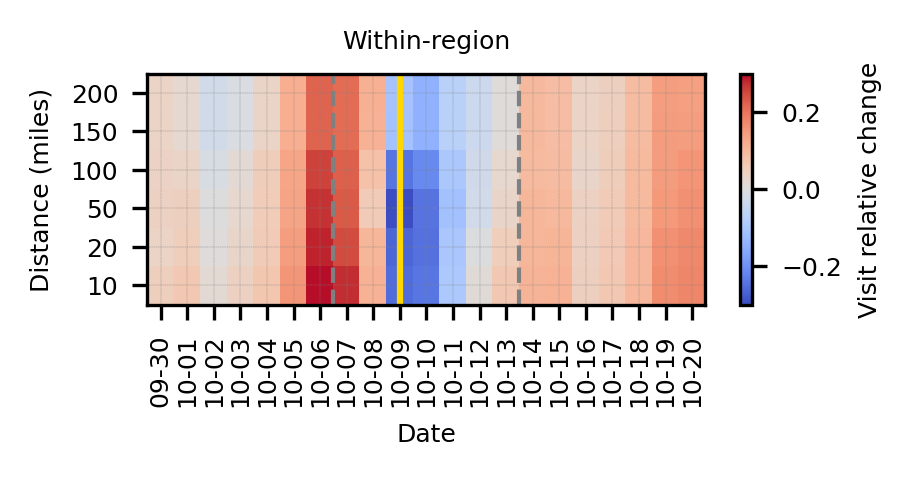

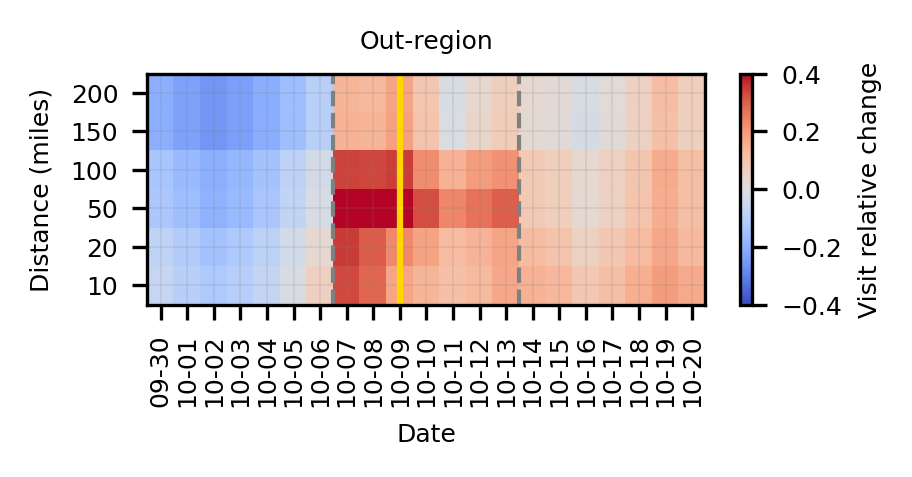

In [10]:
start_date_p = "2024-09-30"
dates_p = pd.date_range(start=start_date_p, periods=3*7, freq="D") 
highlight_date = pd.to_datetime("2024-10-09")
save_path = "../results/{}/".format(hrc_name)

# data = WithinRegion_change
# title = 'Milton Within-region Raw Visit Change'
# mhp.plot_heatmap(data, dates_p, cut_off_ls, highlight_date,title)


data = WithinRegion_relative_change
print (max(np.abs(data.flatten())))
title = 'Within-region'
mhp.plot_heatmap(data, 0.3, dates_p, cut_off_ls, highlight_date,title,save_path)


# data = OutRegion_change
# title = 'Milton Out-region Raw Visit Change'
# mhp.plot_heatmap(data, dates_p, cut_off_ls, highlight_date,title)

data = OutRegion_relative_change
print (max(np.abs(data.flatten())))
title = 'Out-region'
mhp.plot_heatmap(data, 0.4,dates_p, cut_off_ls, highlight_date,title,save_path)

In [17]:
data = WithinRegion_relative_change[2,6:9]
print(data.shape)
print ('mean',np.mean(data)*100)

data = WithinRegion_relative_change[2,9]
print(data.shape)
print ('mean',np.mean(data)*100)
# print(np.median(data)*100)
# q1 = np.percentile(data, 25)*100  # 25th percentile (Q1)
# q3 = np.percentile(data, 75)*100  # 75th percentile (Q3)

# print(f"25th percentile (Q1): {q1}")
# print(f"75th percentile (Q3): {q3}")
# q1, q3 = np.quantile(data, [0.25, 0.75])
# print(f"25th percentile (Q1)-v2: {q1}")
# print(f"75th percentile (Q3)-v2: {q3}")

(3,)
mean 18.651137796909527
()
mean -29.587777617904436


In [18]:
data = OutRegion_relative_change[2,6:9]
print(data.shape)
print ('mean',np.mean(data)*100)

data = OutRegion_relative_change[2,9]
print(data)
print ('mean',np.mean(data)*100)

# print ('median',np.median(data)*100)
# q1 = np.percentile(data, 25)*100  # 25th percentile (Q1)
# q3 = np.percentile(data, 75)*100  # 75th percentile (Q3)

# print(f"25th percentile (Q1): {q1}")
# print(f"75th percentile (Q3): {q3}")

(3,)
mean 29.233848719875805
0.4323392238014713
mean 43.23392238014713


In [18]:
data = WithinRegion_relative_change[:,9]
# print(data.shape)
print(np.median(data)*100)
q1 = np.percentile(data, 25)*100  # 25th percentile (Q1)
q3 = np.percentile(data, 75)*100  # 75th percentile (Q3)

print(f"25th percentile (Q1): {q1}")
print(f"75th percentile (Q3): {q3}")
q1, q3 = np.quantile(data, [0.25, 0.75])
print(f"25th percentile (Q1)-v2: {q1}")
print(f"75th percentile (Q3)-v2: {q3}")

-24.899783589048656
25th percentile (Q1): -26.049272439046177
75th percentile (Q3): -14.235704839293096
25th percentile (Q1)-v2: -0.2604927243904618
75th percentile (Q3)-v2: -0.14235704839293095


In [19]:
data = OutRegion_relative_change[:,9]
print(data.shape)
print ('median',np.median(data)*100)
q1 = np.percentile(data, 25)*100  # 25th percentile (Q1)
q3 = np.percentile(data, 75)*100  # 75th percentile (Q3)

print(f"25th percentile (Q1): {q1}")
print(f"75th percentile (Q3): {q3}")

(6,)
median 20.84526567896817
25th percentile (Q1): 17.957087042655708
75th percentile (Q3): 31.90391072151984
